# Imputation of Missing Data, Financial Analysis, and Delivery to Client

## Cleaning the Dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Load the originial dataset from the beginning of our exploration

df_orig = pd.read_excel("default_of_credit_card_clients__courseware_version_1_21_19.xls")


In [5]:
# Make a Boolean array indicating where entries of the DataFrame are equal to 0

df_zero_mask = df_orig == 0

In [6]:
#Collaspe this 2-d boolean array to 1-d by indicating which rows have 0s in all columns, starting with the second column.

feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)

In [7]:
# check the number of rows with all 0 values for the features in the same as what we found in ch. 1

sum(feature_zero_mask)

315

In [8]:
# Use this mask to select all the other rows, that is those that don't have values of zero for all features and check the resulting 
# dataframe

df_clean = df_orig.loc[~feature_zero_mask,:].copy()
df_clean.shape

(29685, 25)

In [9]:
# Check that the number of unique account IDs is equal to the number of rows of the cleaned dataframe
df_clean["ID"].nunique()

29685

In [10]:
# Replace the undocumented values of EDUCATION and MARRIAGE features with the documented value for "unknown"

df_clean["EDUCATION"].replace(to_replace=[0,5,6],value=4,inplace=True)
df_clean["MARRIAGE"].replace(to_replace=0,value=3,inplace=True)

In [11]:
# Examining the values of PAY_1

df_clean["PAY_1"].value_counts()

0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: PAY_1, dtype: int64

In [12]:
# Create a Boolean mask to id the rows with this value
missing_pay_1_mask = df_clean["PAY_1"] == "Not available"

In [13]:
# Confirming that the number of samples with missing data is 3021

sum(missing_pay_1_mask)

3021

In [14]:
# Making a copy of these rows in a new dataframe which we can add to the data we've been using for modeling

df_missing_pay_1 = df_clean.loc[missing_pay_1_mask,:].copy()

In [15]:
# Load the cleaned data

df = pd.read_csv("chapter_1_cleaned_data.csv")

In [16]:
# Make a list of columns names of this Dataframe and then remove the strings that are not part of the set of features and the 
# response variable

features_response = df.columns.tolist()

In [17]:
#make a list of column names that are not the features or the response 

items_to_remove = ["ID","SEX","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6","EDUCATION_CAT","graduate school","high school","none","others","university"]

In [18]:
#Use a list comprehension to remove the unwanted columns names

features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

## Mode and Random Imputation of PAY_1

In [19]:
# Import module

from sklearn.model_selection import train_test_split

In [20]:
# Create a 80/20 training/testing split using the same random seed 

X_train,X_test,y_train,y_test = train_test_split(df[features_response[:-1]].values, df["default payment next month"].values, test_size=0.2,random_state=24)

In [21]:
# Examining the shapes of the training and testing sets

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 17)
(5333, 17)
(21331,)
(5333,)


In [22]:
# Creating the imputation values for PAY_1

print(features_response[4])

PAY_1


In [23]:
# Checking what the median of PAY_1 is 
np.median(X_train[:,4])

0.0

In [24]:
# Create a list of values to test for imputation 
np.random.seed(seed=1)
fill_values = [0,np.random.choice(X_train[:,4],size=(3021,),replace=True)]

In [25]:
#Create a list of names for the imputation strategies 

fill_strategy = ["mode","random"]

In [26]:
#Examine the second element of the fill_values list

fill_values[-1]

array([ 0,  0,  0, ...,  2,  0, -2], dtype=int64)

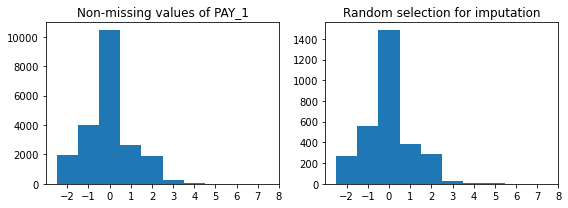

In [27]:
# Use histograms to examine the distrbutions of the original non-missing PAY_1 feature in the training set and the randomly selected 
# imputed values

fig,axs = plt.subplots(1,2,figsize=(8,3))
bin_edges = np.arange(-2,9)
axs[0].hist(X_train[:,4],bins=bin_edges,align="left")
axs[0].set_xticks(bin_edges)
axs[0].set_title("Non-missing values of PAY_1")
axs[1].hist(fill_values[-1],bins=bin_edges,align="left")
axs[1].set_xticks(bin_edges)
axs[1].set_title("Random selection for imputation")
plt.tight_layout()

In [28]:
# Importing the Kfold class

from sklearn.model_selection import KFold

In [30]:
# Instantiate the KFold class

k_folds = KFold(n_splits=4,shuffle=True,random_state=1)

In [31]:
# Import the cross_validate class
from sklearn.model_selection import cross_validate
# Import the random forest classifier class
from sklearn.ensemble import RandomForestClassifier

In [32]:
# Instantiate the random forest class using the hyperparameters we've determined are best for the case study data: 200 trees
# with maximum depth 9

rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=9,min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,random_state=4, verbose=1, warm_start=False, class_weight=None)

In [34]:
# Conducting cross-validation

for counter in range(len(fill_values)):
    df_fill_pay_1_filled = df_missing_pay_1.copy()
    df_fill_pay_1_filled["PAY_1"] = fill_values[counter]

    X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
    train_test_split(df_fill_pay_1_filled[features_response[:-1]].values,df_fill_pay_1_filled['default payment next month'].values,test_size=0.2, random_state=24)
    X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
    y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
    
    imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',cv=k_folds, n_jobs=-1, verbose=1,return_train_score=True, return_estimator=True,error_score='raise-deprecating')
    test_score = imputation_compare_cv['test_score']
    print(fill_strategy[counter] + ' imputation: ' +'mean testing score ' + str(np.mean(test_score)) +', std ' + str(np.std(test_score)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   17.8s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   17.9s finished


mode imputation: mean testing score 0.772866246168149, std 0.0031479941297533737


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   18.8s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   19.0s finished


random imputation: mean testing score 0.7692540439833129, std 0.003660875187678248


## A Predictive Model for PAY_1

In [35]:
# Using a multiclass classification model to predict PAY_1



In [36]:
# First create a copy of the cleaned DataFrame with non-missing values of PAY_1

pay_1_df = df.copy()

In [37]:
# Making a list of column names that will be features

features_for_imputation = pay_1_df.columns.tolist()

In [38]:
# Subset this down to the list of features for the imputation model by removing the names of all metadata as well as "default payment next month"
# which we don't need here and "PAY_1"

items_to_remove = ["ID","SEX","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6","EDUCATION_CAT","graduate school","high school","none","others","university","default payment next month","PAY_1"]

In [39]:
# Remove these items using a list comprehension

features_for_imputation = [item for item in features_for_imputation if item not in items_to_remove]
features_for_imputation

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

## Building a Multiclass Classification Model for Imputation

In [40]:
# Make a training and testing split of the imputation model data


X_impute_train, X_impute_test, y_impute_train, y_impute_test = train_test_split(pay_1_df[features_for_imputation].values,pay_1_df['PAY_1'].values,test_size=0.2, random_state=24)

In [41]:
# Select a grid hyperparameters to search using cross-validation

rf_impute_params = {'max_depth':[3, 6, 9, 12],'n_estimators':[10, 50, 100, 200]}

In [42]:
# Import and instantiate the GridSearchCV class

from sklearn.model_selection import GridSearchCV

cv_rf_impute = GridSearchCV(rf, param_grid=rf_impute_params, scoring='accuracy',n_jobs=-1, refit=True,cv=4, verbose=2, error_score=np.nan, return_train_score=True)

In [43]:
# Run the grid search

cv_rf_impute.fit(X_impute_train, y_impute_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   16.2s finished


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=9, n_estimators=200,
                                              random_state=4, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [44]:
# Observe the hyperparameters from the best model of cross-validation

cv_rf_impute.best_params_

{'max_depth': 12, 'n_estimators': 200}

In [45]:
# The accuracy score of the best model is

cv_rf_impute.best_score_

0.7344242187492307

In [46]:
# Examining the value counts of PAY_1 in pay_1_df to see the relative frequency of different values
pay_1_value_counts = pay_1_df["PAY_1"].value_counts().sort_index()
pay_1_value_counts

-2     2476
-1     5047
 0    13087
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: PAY_1, dtype: int64

In [47]:
#Show the relative frequency of PAY_1 values as fractions 

pay_1_value_counts/pay_1_value_counts.sum()

-2    0.092859
-1    0.189281
 0    0.490812
 1    0.122300
 2    0.089184
 3    0.010951
 4    0.002363
 5    0.000863
 6    0.000413
 7    0.000338
 8    0.000638
Name: PAY_1, dtype: float64

In [48]:
# Checking that the cross-validation accuracy generalizes to the test set

y_impute_predict = cv_rf_impute.predict(X_impute_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


In [49]:
# Importing the accuracy_score class to see the accuracy of testing predictions
from sklearn import metrics

metrics.accuracy_score(y_impute_test,y_impute_predict)

0.7391711981998875

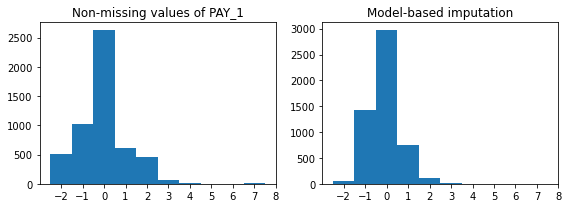

In [50]:
# Plotting actual values and predictions for the held-out test set

fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].hist(y_impute_test, bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(y_impute_predict, bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Model-based imputation')
plt.tight_layout()

In [51]:
#Collecting all the values with known PAY_1 to train the final version of the imputation model
X_impute_all = pay_1_df[features_for_imputation].values
y_impute_all = pay_1_df['PAY_1'].values

In [52]:
# Define a random forest model with the optimal hyperparameters for imputation

rf_impute = RandomForestClassifier(n_estimators = 100, max_depth=12)

In [53]:
# Fit the imputation model on all available data

rf_impute.fit(X_impute_all,y_impute_all)

RandomForestClassifier(max_depth=12)

## Using the Imputation Model and Comparing it to Other Methods

In [54]:
# Making a copy of the DataFrame with the missing PAY_1 data
df_fill_pay_1_model = df_missing_pay_1.copy()
df_fill_pay_1_model["PAY_1"].head()

17    Not available
28    Not available
29    Not available
54    Not available
60    Not available
Name: PAY_1, dtype: object

In [55]:
# Replace the missing values with the imputation model predictions

df_fill_pay_1_model["PAY_1"] = rf_impute.predict(df_fill_pay_1_model[features_for_imputation].values)

In [56]:
#Examining the values of PAY_1 to confirm that they have been imputed

df_fill_pay_1_model["PAY_1"].head()

17    0
28   -1
29    0
54    0
60    0
Name: PAY_1, dtype: int64

In [57]:
# Examining the predictions using the value_counts method

df_fill_pay_1_model["PAY_1"].value_counts().sort_index()

-2      30
-1     763
 0    1715
 1     438
 2      64
 3       7
 4       2
 6       1
 8       1
Name: PAY_1, dtype: int64

In [58]:
#Splitting the model imputed data as follows


X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = train_test_split(df_fill_pay_1_model[features_response[:-1]].values,df_fill_pay_1_model['default payment next month'].values,test_size=0.2, random_state=24)

In [59]:
# Combine this with the data with known PAY_1

X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

In [60]:
# Comfirm that the rf object still holds the model with optimal hyperparameters for the case study
rf

RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

In [61]:
# Use this model with the combined imputed and non-missing training data in cross-validation as we did with the other imputation
# methods, to test model-based imputation

imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',cv=k_folds, n_jobs=-1, verbose=1,return_train_score=True, return_estimator=True,error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   26.2s remaining:   26.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   26.4s finished


In [63]:
#Examining the avg model testing score across the four folds
np.mean(imputation_compare_cv["test_score"])

0.7726757126815554

In [64]:
#Using mode based imputation was better so that what we will use

df_fill_pay_1_model["PAY_1"] = np.zeros_like(df_fill_pay_1_model["PAY_1"].values)

In [65]:
# We repeat the splitting of the imputed data

X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = train_test_split(df_fill_pay_1_model[features_response[:-1]].values,df_fill_pay_1_model['default payment next month'].values,test_size=0.2, random_state=24)

In [66]:
# Combining the non-missing data, this time including the unseen test set

X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

In [67]:
# To confirm that the data has been restored to the state it was in when we tested mode-based imputation earlier we run the
# cross-validation to confirm that we get the same score

imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',cv=k_folds, n_jobs=-1, verbose=1,return_train_score=True, return_estimator=True,error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   26.6s remaining:   26.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   26.7s finished


In [68]:
# After running the cross-validation compute the avg score
np.mean(imputation_compare_cv["test_score"])

0.772866246168149

In [69]:
# Using the training and testing data to train the final model

rf.fit(X_train_all,y_train_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   12.2s finished


RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

In [70]:
# Making the predictions for credit default on the testing set. We need to predict probabilities to calculate ROC AUC

y_test_all_predict_proba = rf.predict_proba(X_test_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished


In [71]:
# Import the roc_auc_score function and calculate the testing score

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_all, y_test_all_predict_proba[:,1])

0.7696243835824927

# Characterizing Costs and Savings

In [72]:
# Create a range of thresholds to calculate expected costs and benefits of counseling

thresholds = np.linspace(0,1,101)

In [73]:
# Confirm the index of the testing data features array that corresponds to the most recent month's bill
df[features_response[:-1]].columns[5]

'BILL_AMT1'

In [74]:
# Capture the avg bill amount as the potential savings per default and observe it

savings_per_default = np.mean(X_test_all[:, 5])
savings_per_default

51601.7433479286

In [75]:
#Store the cost of counseling in a variable to use for analysis
cost_per_counseling = 7500



In [76]:
#Store the effectiveness rate the client gave us for use in analysis
effectiveness = 0.70

In [77]:
#Create empty arrays to store analysis results
n_pos_pred = np.empty_like(thresholds)
cost_of_all_counselings = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
savings_of_all_counselings = np.empty_like(thresholds)

In [78]:
# Make a counter variable and open a for loop to go through thresholds

counter = 0

In [80]:
# Determine which accounts get positive predictions 
counter = 0
for threshold in thresholds:
    pos_pred = y_test_all_predict_proba[:,1]>threshold
    n_pos_pred[counter] = sum(pos_pred)
    cost_of_all_counselings[counter] = n_pos_pred[counter] * cost_per_counseling
    true_pos = pos_pred & y_test_all.astype(bool)
    n_true_pos[counter] = sum(true_pos)
    savings_of_all_counselings[counter] = n_true_pos[counter] * savings_per_default * effectiveness
    
    counter += 1

In [81]:
#Calculate net savings for all the theresholds by subtracting the savings and cost arrays

net_savings = savings_of_all_counselings - cost_of_all_counselings

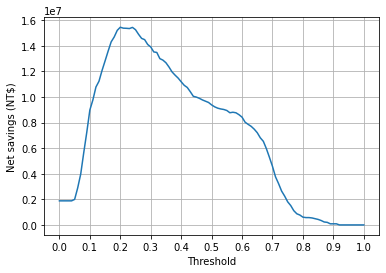

In [82]:
# Plot the net saving against the threshold
plt.plot(thresholds,net_savings)
plt.xlabel("Threshold")
plt.ylabel("Net savings (NT$)")
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

In [83]:
# Find the index of the largest element of the net saving array using numpy's argmax

max_savings_ix = np.argmax(net_savings)

In [84]:
# Display the threshold that results in the greatest net savings

thresholds[max_savings_ix]

0.2

In [85]:
# Display the greatest possible net savings

net_savings[max_savings_ix]

15446325.35991916